<font size="6">Calculate GHG Intensity per GDP, PPP </font>

In [1]:
# 'capture' magic prevents long outputs from spamming your notebook
#%%capture pipoutput

# For loading predefined environment variables from files
# Typically used to load sensitive access credentials
%pip install python-dotenv

# Standard python package for interacting with S3 buckets
%pip install boto3

# Interacting with Trino and using Trino with sqlalchemy
%pip install trino sqlalchemy sqlalchemy-trino

# Pandas and parquet file i/o
%pip install pandas pyarrow fastparquet

# OS-Climate utilities to make data ingest easier
%pip install osc-ingest-tools
%pip install ipython --upgrade
%pip install jedi

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from dotenv import dotenv_values, load_dotenv
import osc_ingest_trino as osc
import os
import pathlib

<font size="4">Load Environment Variables</font>

In [3]:
dotenv_dir = os.environ.get('CREDENTIAL_DOTENV_DIR', os.environ.get('PWD', '/opt/app-root/src'))
dotenv_path = pathlib.Path(dotenv_dir) / 'credentials.env'
if os.path.exists(dotenv_path):
    load_dotenv(dotenv_path=dotenv_path,override=True)

In [4]:
import trino
from sqlalchemy.engine import create_engine

env_var_prefix = 'TRINO'

sqlstring = 'trino://{user}@{host}:{port}/'.format(
    user = os.environ[f'{env_var_prefix}_USER'],
    host = os.environ[f'{env_var_prefix}_HOST'],
    port = os.environ[f'{env_var_prefix}_PORT']
)
sqlargs = {
    'auth': trino.auth.JWTAuthentication(os.environ[f'{env_var_prefix}_PASSWD']),
    'http_scheme': 'https',
    'catalog': 'osc_datacommons_dev'
}
engine = create_engine(sqlstring, connect_args = sqlargs)
connection = engine.connect()

trino_bucket = osc.attach_s3_bucket("S3_DEV")

/opt/app-root/lib64/python3.8/site-packages/sqlalchemy_trino/dialect.py:259: SAWarning: Dialect trino:rest will not make use of SQL compilation caching as it does not set the 'supports_statement_cache' attribute to ``True``.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Dialect maintainers should seek to set this attribute to True after appropriate development and testing for SQLAlchemy 1.4 caching support.   Alternatively, this attribute may be set to False which will disable this warning. (Background on this error at: https://sqlalche.me/e/14/cprf)
  res = connection.execute(sql.text(query)).scalar()


In [5]:
import boto3

s3_source = boto3.resource(
    service_name="s3",
    endpoint_url=os.environ['S3_LANDING_ENDPOINT'],
    aws_access_key_id=os.environ['S3_LANDING_ACCESS_KEY'],
    aws_secret_access_key=os.environ['S3_LANDING_SECRET_KEY'],
)
source_bucket = s3_source.Bucket(os.environ['S3_LANDING_BUCKET'])

Open a Trino connection using JWT for authentication

In [6]:
# Show available schemas to ensure trino connection is set correctly
ingest_catalog = 'osc_datacommons_dev'
schema_read = engine.execute(f'show schemas in {ingest_catalog}')
for row in schema_read.fetchall():
    print(row)

('default',)
('demo_dv',)
('iceberg_demo',)
('information_schema',)
('pcaf_sovereign_footprint',)
('sandbox',)


In [7]:
# define source and destination tables
# LULUCF (Land Use, Land-Use Change and Forestry)

ingest_schema = 'pcaf_sovereign_footprint'
ingest_table = 'sf_unfccc_results'
src_table_1 = 'sf_unfccc_with_lulucf'
src_table_2 = 'sf_unfccc_without_lulucf'
src_table_3 = 'sf_wdi_gdp'


In [8]:
def requantify_df(df):
    units_col = None
    columns_reversed = reversed(df.columns)
    for col in columns_reversed:
        if col.endswith("_units"):
            if units_col:
                # We expect _units column to follow a non-units column
                raise ValueError
            units_col = col
            continue
        if units_col:
            if col + '_units' != units_col:
                raise ValueError
            if (df[units_col]==df[units_col][0]).all():
                # Make a PintArray
                new_col = PintArray(df[col], dtype=f"pint[{ureg(df[units_col][0]).u}]")
            else:
                # Make a pd.Series of Quantity in a way that does not throw UnitStrippedWarning
                new_col = pd.Series(data=df[col], name=col) * pd.Series(data=df[units_col].map(lambda x: ureg(x).u), name=col)
            df = df.drop(columns=units_col)
            df[col] = new_col
            units_col = None
    return df


In [9]:
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plot
import pandas as pd
import pint
from pint import set_application_registry, Quantity
from pint_pandas import PintArray, PintType
from pint_pandas.pint_array import is_pint_type
from openscm_units import unit_registry
#PintType.ureg = unit_registry
ureg = unit_registry
Q_ = ureg.Quantity
ureg.define("CO2e=CO2=CO2eq=CO2_eq")
ureg.define("USD=[currency]=$")
set_application_registry(ureg)



sql=f"""
select country_iso_code,country_name,validity_date,attribute,value,value_units from {ingest_catalog}.{ingest_schema}.{src_table_1} """ 
df1 = pd.read_sql(sql, engine)
#df1["units"] = "kt"
df1 = requantify_df(df1).convert_dtypes()
df1
df1.info(verbose=True)
sql=f"""
select country_iso_code,country_name,validity_date,attribute,value,value_units from {ingest_catalog}.{ingest_schema}.{src_table_2}"""
df2 = pd.read_sql(sql, engine)
df2 = requantify_df(df2).convert_dtypes()
#df2
sql=f"""
select country_iso_code,validity_date,value,value_units from {ingest_catalog}.{ingest_schema}.{src_table_3} """
df3 = pd.read_sql(sql, engine)
df3 = requantify_df(df3).convert_dtypes()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1305 entries, 0 to 1304
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   country_iso_code  1305 non-null   string         
 1   country_name      1305 non-null   string         
 2   validity_date     1305 non-null   Int64          
 3   attribute         1305 non-null   string         
 4   value             1305 non-null   pint[CO2e * kt]
dtypes: Int64(1), pint[CO2e * kt](1), string(3)
memory usage: 52.4 KB


Read the source tables into dataframes  

<font size="4">Merge the source dataframes in a single dataframe and calculate ghg intensity values</font>

In [10]:

df_result = pd.merge(df1,df2,on=['country_iso_code','validity_date'])  
df_result=df_result.convert_dtypes()
df_result.drop(columns=['country_name_y','attribute_x','attribute_y'],inplace=True)
df_result.rename(columns={"country_name_x":"country_name","value_x": "ghg_total_with_lulucf", "value_y": "ghg_total_without_lulucf"},inplace=True)

###

df_result = pd.merge(df_result,df3,on=['country_iso_code','validity_date'],how="inner")  
df_result.rename(columns={"value":"gdp"},inplace=True)
df_result["ghg_intensity_with_lulucf_per_gdp"] = df_result["ghg_total_with_lulucf"]/df_result["gdp"]*1000000
df_result["ghg_intensity_without_lulucf_per_gdp"] = df_result["ghg_total_without_lulucf"]/df_result["gdp"]*1000000
df_result.info(verbose=True)



<class 'pandas.core.frame.DataFrame'>
Int64Index: 1149 entries, 0 to 1148
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype                
---  ------                                --------------  -----                
 0   country_iso_code                      1149 non-null   string               
 1   country_name                          1149 non-null   string               
 2   validity_date                         1149 non-null   Int64                
 3   ghg_total_with_lulucf                 1149 non-null   pint[CO2e * kt]      
 4   ghg_total_without_lulucf              1149 non-null   pint[CO2e * kt]      
 5   gdp                                   1149 non-null   pint[USD]            
 6   ghg_intensity_with_lulucf_per_gdp     1149 non-null   pint[CO2e * kt / USD]
 7   ghg_intensity_without_lulucf_per_gdp  1149 non-null   pint[CO2e * kt / USD]
dtypes: Int64(1), pint[CO2e * kt / USD](2), pint[CO2e * kt](2), pint[USD](1), string

In [11]:
# If DF_COL contains Pint quantities (because it is a PintArray or an array of Pint Quantities),
# return a two-column dataframe of magnitudes and units.
# If DF_COL contains no Pint quanities, return it unchanged.

def dequantify_column(df_col: pd.Series):
    if type(df_col.values)==PintArray:
        return pd.DataFrame({df_col.name: df_col.values.quantity.m,
                             df_col.name + "_units": str(df_col.values.dtype.units)},
                            index=df_col.index)
    elif df_col.size==0:
        return df_col
    elif isinstance(df_col.iloc[0], Quantity):
        values = df_col.map(lambda x: (x.m, x.u))
        return pd.DataFrame({df_col.name: df_col.map(lambda x: x.m),
                             df_col.name + "_units": df_col.map(lambda x: str(x.u))},
                            index=df_col.index)
    else:
        return df_col

# Rewrite dataframe DF so that columns containing Pint quantities are represented by a column for the Magnitude and column for the Units.
# The magnitude column retains the original column name and the units column is renamed with a _units suffix.
def dequantify_df(df):
    return pd.concat([dequantify_column(df[col]) for col in df.columns], axis=1)

In [12]:
df1 = dequantify_df(df1)
df2 = dequantify_df(df2)
df3 = dequantify_df(df3)
df_result = dequantify_df(df_result)
df_result=df_result.convert_dtypes()
df_result.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1149 entries, 0 to 1148
Data columns (total 13 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   country_iso_code                            1149 non-null   string 
 1   country_name                                1149 non-null   string 
 2   validity_date                               1149 non-null   Int64  
 3   ghg_total_with_lulucf                       1149 non-null   Float64
 4   ghg_total_with_lulucf_units                 1149 non-null   string 
 5   ghg_total_without_lulucf                    1149 non-null   Float64
 6   ghg_total_without_lulucf_units              1149 non-null   string 
 7   gdp                                         1149 non-null   Float64
 8   gdp_units                                   1149 non-null   string 
 9   ghg_intensity_with_lulucf_per_gdp           1149 non-null   Float64
 10  ghg_intensit

In [13]:

# make sure schema exists, or table creation below will fail in weird ways
sql = f"""
CREATE SCHEMA if not exists {ingest_catalog}.{ingest_schema}
 AUTHORIZATION USER mersin35
 WITH (
     location = 's3a://osc-datacommons-s3-bucket-dev02/data/pcaf_covereign.db'
 )
"""
print(sql)
qres = engine.execute(sql)
print(qres.fetchall())


CREATE SCHEMA if not exists osc_datacommons_dev.pcaf_sovereign_footprint
 AUTHORIZATION USER mersin35
 WITH (
     location = 's3a://osc-datacommons-s3-bucket-dev02/data/pcaf_covereign.db'
 )

[(True,)]


<font size="5">Show the GHG intensity per GDP chart  (with LULUCF)</font>


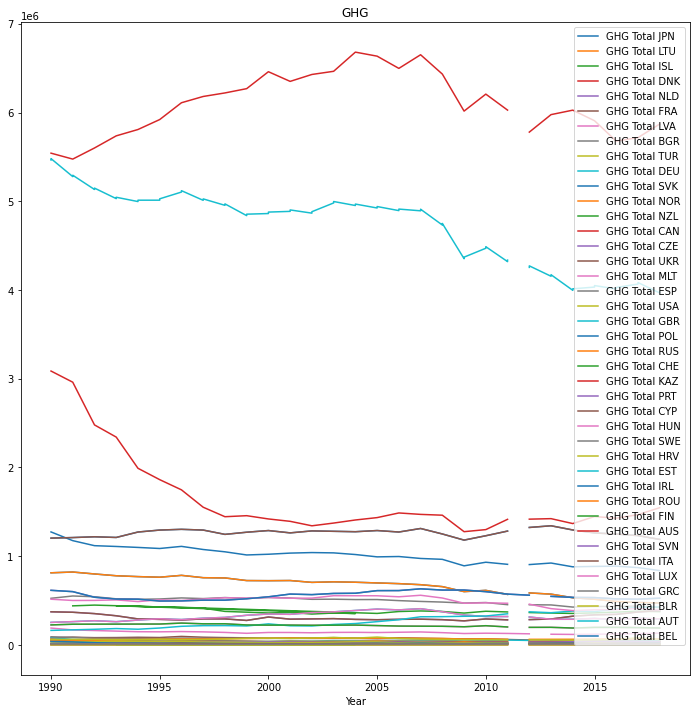

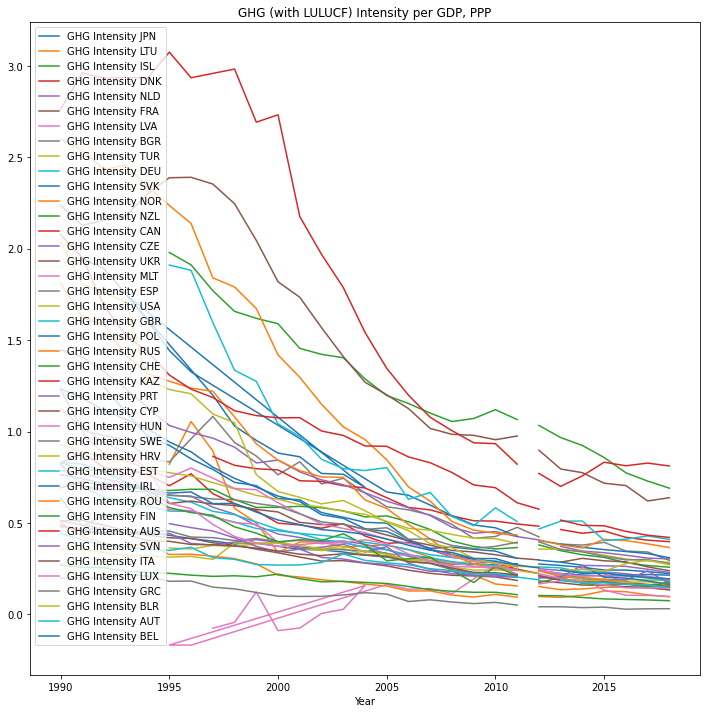

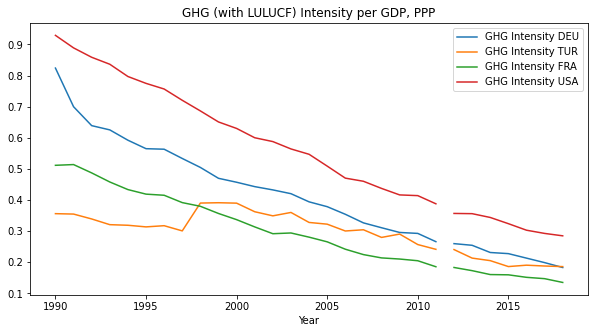

In [14]:
# save the list of countries 
df_cty= df_result[['country_iso_code','country_name']]
df_cty= df_cty.drop_duplicates()

# prepare the dictionary for the graph

ghg_with_lulucf = {"Year":  df1['validity_date']}



ghg_intensity_with_lulucf = {"Year":  df_result['validity_date']}
#ghg_with_lulucf = {"Year":  df_result['validity_date']}


for ind in df_cty.index:
     ghg_intensity_with_lulucf["GHG Intensity " + df_cty['country_iso_code'][ind]] = df_result[(df_result['country_iso_code']==df_cty['country_iso_code'][ind])]['ghg_intensity_with_lulucf_per_gdp']
     ghg_with_lulucf["GHG Total " + df_cty['country_iso_code'][ind]] = df1[(df1['country_iso_code']==df1['country_iso_code'][ind])]['value']         

        
      
    
     

     

    
     #ghg_with_lulucf["GHG with LULUCF " + df_cty['country_iso_code'][ind]] = df1[(df1['country_iso_code']==df_cty['country_iso_code'][ind])]['value'];        
     

        
             
plot.rcParams["figure.figsize"] = (12, 12)

df = pd.DataFrame(data=ghg_with_lulucf);

df.plot.line(x="Year", title="GHG");

plot.show(block=True);


df = pd.DataFrame(data=ghg_intensity_with_lulucf);

df.plot.line(x="Year", title="GHG (with LULUCF) Intensity per GDP, PPP");

plot.show(block=True);


# show only for DEU, FRA, USA, TUR

ghg_intensity_with_lulucf = {"Year":  df_result['validity_date'],
    
              "GHG Intensity DEU": df_result[(df_result['country_iso_code']=='DEU')]['ghg_intensity_with_lulucf_per_gdp'] ,
              
              "GHG Intensity TUR": df_result[(df_result['country_iso_code']=='TUR')]['ghg_intensity_with_lulucf_per_gdp'] ,                  
                             
              "GHG Intensity FRA": df_result[(df_result['country_iso_code']=='FRA')]['ghg_intensity_with_lulucf_per_gdp'] ,
              
              "GHG Intensity USA": df_result[(df_result['country_iso_code']=='USA')]['ghg_intensity_with_lulucf_per_gdp']                   
              };


#df = pd.DataFrame(data=ghg_intensity_without_lulucf);

plot.rcParams["figure.figsize"] = (10, 5)

df = pd.DataFrame(data=ghg_intensity_with_lulucf);

df.plot.line(x="Year", title="GHG (with LULUCF) Intensity per GDP, PPP");

plot.show(block=True);




Run these in a notebook cell if you need to install onto your nb env

<font size="5">Show the GHG intensity per GDP chart  (without LULUCF)</font>


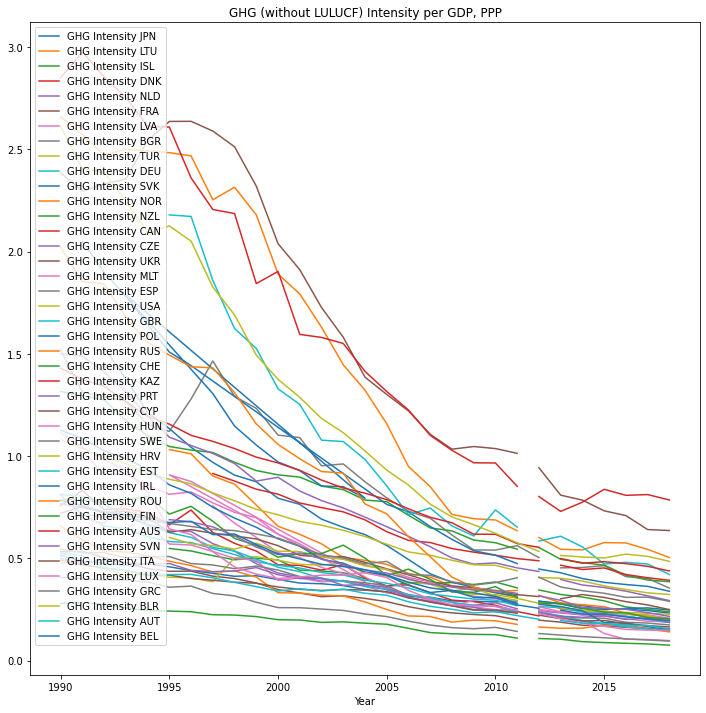

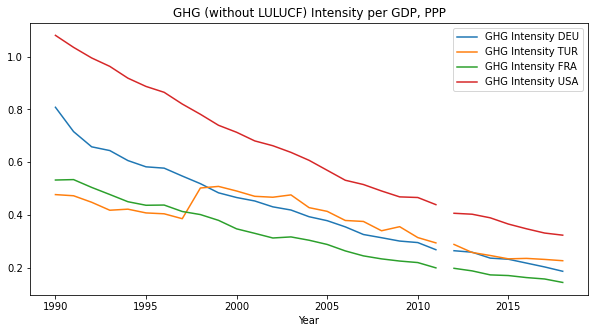

In [15]:
# prepare the dictionary for the graph

ghg_intensity_without_lulucf = {"Year":  df_result['validity_date']}

for ind in df_cty.index:
     ghg_intensity_without_lulucf["GHG Intensity " + df_cty['country_iso_code'][ind]] = df_result[(df_result['country_iso_code']==df_cty['country_iso_code'][ind])]['ghg_intensity_without_lulucf_per_gdp']
        
             
plot.rcParams["figure.figsize"] = (12, 12)

df = pd.DataFrame(data=ghg_intensity_without_lulucf);

df.plot.line(x="Year", title="GHG (without LULUCF) Intensity per GDP, PPP");

plot.show(block=True);


# show only for DEU, FRA, USA, TUR

ghg_intensity_without_lulucf = {"Year":  df_result['validity_date'],
    
              "GHG Intensity DEU": df_result[(df_result['country_iso_code']=='DEU')]['ghg_intensity_without_lulucf_per_gdp'] ,
              
              "GHG Intensity TUR": df_result[(df_result['country_iso_code']=='TUR')]['ghg_intensity_without_lulucf_per_gdp'] ,                  
                             
              "GHG Intensity FRA": df_result[(df_result['country_iso_code']=='FRA')]['ghg_intensity_without_lulucf_per_gdp'] ,
              
              "GHG Intensity USA": df_result[(df_result['country_iso_code']=='USA')]['ghg_intensity_without_lulucf_per_gdp']                   
              };


#df = pd.DataFrame(data=ghg_intensity_without_lulucf);

plot.rcParams["figure.figsize"] = (10, 5)

df = pd.DataFrame(data=ghg_intensity_without_lulucf);

df.plot.line(x="Year", title="GHG (without LULUCF) Intensity per GDP, PPP");

plot.show(block=True);



<font size="5">Save the results in Trino</font>


In [16]:

# make sure schema exists, or table creation below will fail in weird ways
sql = f"""
CREATE SCHEMA if not exists {ingest_catalog}.{ingest_schema}
 AUTHORIZATION USER mersin35
 WITH (
     location = 's3a://osc-datacommons-s3-bucket-dev02/data/pcaf_covereign.db'
 )
"""
print(sql)
qres = engine.execute(sql)
print(qres.fetchall())


CREATE SCHEMA if not exists osc_datacommons_dev.pcaf_sovereign_footprint
 AUTHORIZATION USER mersin35
 WITH (
     location = 's3a://osc-datacommons-s3-bucket-dev02/data/pcaf_covereign.db'
 )

[(True,)]


In [17]:
import osc_ingest_trino as osc
#df_result['validity_date']=pd.to_datetime(df_result['validity_date'], unit='D')
#df_result=df_result.convert_dtypes()
#df_result.info()
columnschema = osc.create_table_schema_pairs(df_result) 
sql = f"""
drop table if exists {ingest_catalog}.{ingest_schema}.{ingest_table}
"""
print(sql)
qres = engine.execute(sql)
print(qres.fetchall())




drop table if exists osc_datacommons_dev.pcaf_sovereign_footprint.sf_unfccc_results

[(True,)]


In [18]:
tabledef = f"""
create table if not exists {ingest_catalog}.{ingest_schema}.{ingest_table}(
{columnschema}
) with (
    format = 'ORC',
    partitioning = array['country_iso_code']
)
"""
print(tabledef)
qres = engine.execute(tabledef)
print(qres.fetchall())


create table if not exists osc_datacommons_dev.pcaf_sovereign_footprint.sf_unfccc_results(
    country_iso_code varchar,
    country_name varchar,
    validity_date bigint,
    ghg_total_with_lulucf double,
    ghg_total_with_lulucf_units varchar,
    ghg_total_without_lulucf double,
    ghg_total_without_lulucf_units varchar,
    gdp double,
    gdp_units varchar,
    ghg_intensity_with_lulucf_per_gdp double,
    ghg_intensity_with_lulucf_per_gdp_units varchar,
    ghg_intensity_without_lulucf_per_gdp double,
    ghg_intensity_without_lulucf_per_gdp_units varchar
) with (
    format = 'ORC',
    partitioning = array['country_iso_code']
)

[(True,)]


In [19]:
# Delete all data from our db, so we start with empty table
sql=f"""
delete from {ingest_catalog}.{ingest_schema}.{ingest_table}
"""
qres = engine.execute(sql)
print(qres.fetchall())

[(None,)]


In [20]:
sql=f"""
select * from {ingest_catalog}.{ingest_schema}.{ingest_table}
"""
pd.read_sql(sql, engine)


,country_iso_code,country_name,validity_date,ghg_total_with_lulucf,ghg_total_with_lulucf_units,ghg_total_without_lulucf,ghg_total_without_lulucf_units,gdp,gdp_units,ghg_intensity_with_lulucf_per_gdp,ghg_intensity_with_lulucf_per_gdp_units,ghg_intensity_without_lulucf_per_gdp,ghg_intensity_without_lulucf_per_gdp_units


In [21]:
print(ingest_catalog)
#df=df.drop(df[df.country_name=="cote d'ivoire"].index)
df_result.to_sql(ingest_table,
           con=engine,
           schema=ingest_schema,
           if_exists='append',
           index=False,
           method=osc.TrinoBatchInsert(batch_size = 1000, verbose = True))

osc_datacommons_dev
constructed fully qualified table name as: "pcaf_sovereign_footprint.sf_unfccc_results"
inserting 1000 records
  ('JPN', 'Japan', 2012, 1323805.2853497674, 'CO2e * kt', 1394043.9930774327, 'CO2e * kt', 4799612889015.1, 'USD', 0.2758150117438779, 'CO2e * kt / USD', 0.2904492560781285, 'CO2e * kt / USD')
  ('JPN', 'Japan', 2013, 1342828.7983589931, 'CO2e * kt', 1405888.605187905, 'CO2e * kt', 5021591088716.88, 'USD', 0.2674110206576206, 'CO2e * kt / USD', 0.2799687549921829, 'CO2e * kt / USD')
  ('JPN', 'Japan', 2014, 1295558.4232438065, 'CO2e * kt', 1356588.5369071728, 'CO2e * kt', 5034454618847.27, 'USD', 0.2573383854516596, 'CO2e * kt / USD', 0.2694608730464212, 'CO2e * kt / USD')
  ...
  ('BLR', 'Belarus', 2018, 49725.68666776099, 'CO2e * kt', 89064.61107960099, 'CO2e * kt', 183398223823.045, 'USD', 0.27113505044487063, 'CO2e * kt / USD', 0.4856350798987919, 'CO2e * kt / USD')
batch insert result: [(1000,)]
inserting 149 records
  ('KAZ', 'Kazakhstan', 2012, 28531

In [22]:
sql=f"""
select * from {ingest_catalog}.{ingest_schema}.{ingest_table}"""
pd.read_sql(sql, engine)


,country_iso_code,country_name,validity_date,ghg_total_with_lulucf,ghg_total_with_lulucf_units,ghg_total_without_lulucf,ghg_total_without_lulucf_units,gdp,gdp_units,ghg_intensity_with_lulucf_per_gdp,ghg_intensity_with_lulucf_per_gdp_units,ghg_intensity_without_lulucf_per_gdp,ghg_intensity_without_lulucf_per_gdp_units
0,GBR,United Kingdom of Great Britain and Northern I...,2012,586175.609453,CO2e * kt,580418.639381,CO2e * kt,2.453352e+12,USD,0.238928,CO2e * kt / USD,0.236582,CO2e * kt / USD
1,GBR,United Kingdom of Great Britain and Northern I...,2013,572414.860874,CO2e * kt,566545.826967,CO2e * kt,2.579159e+12,USD,0.221939,CO2e * kt / USD,0.219663,CO2e * kt / USD
2,GBR,United Kingdom of Great Britain and Northern I...,2014,531993.697832,CO2e * kt,526556.300122,CO2e * kt,2.686202e+12,USD,0.198047,CO2e * kt / USD,0.196023,CO2e * kt / USD
3,GBR,United Kingdom of Great Britain and Northern I...,2015,514865.760436,CO2e * kt,509050.717772,CO2e * kt,2.794324e+12,USD,0.184254,CO2e * kt / USD,0.182173,CO2e * kt / USD
4,GBR,United Kingdom of Great Britain and Northern I...,2016,489586.025152,CO2e * kt,484146.194849,CO2e * kt,2.928593e+12,USD,0.167174,CO2e * kt / USD,0.165317,CO2e * kt / USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1144,BEL,Belgium,2016,116207.015593,CO2e * kt,117689.179213,CO2e * kt,5.506776e+11,USD,0.211025,CO2e * kt / USD,0.213717,CO2e * kt / USD
1145,BEL,Belgium,2017,116020.409230,CO2e * kt,117424.302916,CO2e * kt,5.737888e+11,USD,0.202201,CO2e * kt / USD,0.204647,CO2e * kt / USD
1146,BEL,Belgium,2018,116780.820463,CO2e * kt,117894.737828,CO2e * kt,6.002416e+11,USD,0.194556,CO2e * kt / USD,0.196412,CO2e * kt / USD
1147,BEL,Belgium,2014,112973.758942,CO2e * kt,114731.995511,CO2e * kt,5.036194e+11,USD,0.224324,CO2e * kt / USD,0.227815,CO2e * kt / USD
